In [1]:
import pandas as pd
import numpy as np
import scipy.stats as st
import matplotlib.pyplot as plt
from sklearn import neighbors
from sklearn.metrics import hamming_loss
import seaborn as sns
from sklearn.decomposition import PCA

In [2]:
def scaleMatrix(matrix):
    return matrix.div(matrix.sum(axis=1),axis=0)

In [3]:
def norm(series):
    b = max(series)
    a = min(series)
    return [(x - a) / (b - a) for x in series]

In [4]:
def npmc(init_state, matrix, original_states, init_state_col):
    matrix = scaleMatrix(matrix)
    probs = {k:list(matrix.iloc[original_states.index(k)]) for k in original_states}
    NewState = []
    for x in range(len(init_state)):
        NewState.append(np.random.choice(a = matrix.columns, p = probs[init_state[init_state_col][x]],size=1)[0])
    NextStep = pd.DataFrame()
    NextStep["Original State"] = init_state[init_state_col]
    NextStep["New State"] = NewState
    return NextStep

In [5]:
def chain(init_state, matrix, original_states, init_state_col,n):
    init_state = init_state.copy()
    out = pd.DataFrame()
    out[0] = init_state[init_state_col]
    for i in range(1,n+1):
        out[i] = npmc(out,matrix,original_states,i-1)["New State"]
    return out

In [6]:
def proj(inp,X1,X2,n,start_state_col):
    sts = []
    inp.reset_index(drop = True,inplace = True)
    curr_st = inp[start_state_col].iloc[0]
    for step in range(n):
        sts.append(curr_st)
        if curr_st == -1:
            try:
                up_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            except:
                up_prob = 0
            try:
                down_prob = npdfd["t1"].iloc[downknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[0] / n_neighbors
            except:
                down_prob = 1- up_prob
            curr_st = np.random.choice([0,1],1,p = [down_prob, up_prob])[0]
        else:
            try:
                up_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[1] / n_neighbors
            except:
                up_prob = 0
            try:
                down_prob = npdfu["t1"].iloc[upknn.kneighbors([[inp[X1][step],inp[X2][step]]],n_neighbors,False)[0]].value_counts()[0] / n_neighbors
            except:
                down_prob = 1 - up_prob
            curr_st = np.random.choice([0,1],1,p = [down_prob, up_prob])[0]
    return sts

In [7]:
tick = pd.read_csv("NASDAQ_Ticks.csv")
all_data = {}
all_tm = {}
returns = {}
for x in tick["Ticker"]:
    
    df = pd.DataFrame()
    t0 = pd.read_csv(x+".csv")["Adj Close"]
    if len(t0) > 60:
        returns[x] = t0.pct_change().iloc[::3][1:]
        df["MMYYYY"] = [x[5:7] + x[:4] for x in pd.read_csv(x+".csv")["Date"][1:]]
        df.reset_index(drop = True,inplace = True)
        df["t0"] = np.where(t0.pct_change()[1:] > 0, 1, 0)
        df.dropna(inplace=True)
        df.reset_index(drop = True,inplace = True)

        df["t1"] = df["t0"].shift(-3)
        df.dropna(inplace=True)
        df.reset_index(drop = True,inplace = True)

        states = ["Up","Down"]
        TM = pd.DataFrame(index = ["Up","Down"])

        tm = {"UU":0,"UD":0,"DU":0,"DD":0}

        for i in range(2,len(df)):

            if df["t0"][i] == 1 and df["t0"][i-1] == 1:
                tm["UU"] += 1
            elif df["t0"][i] == 0 and df["t0"][i-1] == 1:
                tm["UD"] += 1
            elif df["t0"][i] == 1 and df["t0"][i-1] == 0:
                tm["DU"] += 1
            else:
                tm["DD"] += 1

        TM["Up"] = [tm["UU"],tm["UD"]]
        TM["Down"] = [tm["DU"],tm["DD"]]

        findf = pd.read_csv(x + "_quarterly_valuation_measures.csv",header=None).T
        findf.columns = findf.iloc[0]
        findf.drop([0,1],inplace=True)

        findf1 = pd.DataFrame()
        findf1["MMYYYY"] = [y[:2]+ y[6:10] for y in findf["name"].str.replace('/', '-')]
        try:
            findf1["PeRatio"] = norm(np.log(findf["PeRatio"].str.replace(',', '').astype(float)+1))
        except:
            findf1["PeRatio"] = norm(np.log(findf["PegRatio"].str.replace(',', '').astype(float)*0.18+1))
        findf1["PsRatio"] = norm(np.log(findf["PsRatio"].str.replace(',', '').astype(float)+1))
        findf1["PbRatio"] = norm(np.log(findf["PbRatio"].str.replace(',', '').astype(float)+1))
        findf1['MarketCap'] = norm(np.log(findf['MarketCap'].str.replace(',', '').astype(float)+1))
        findf1['EV'] = norm(np.log(findf['EnterpriseValue'].str.replace(',', '').astype(float)+1))
        findf1['EVtoEBITDA'] = norm(np.log(findf['EnterprisesValueEBITDARatio'].str.replace(',', '').astype(float)+1))
        findf1.interpolate(method='linear',inplace=True)

        findf1.dropna(inplace=True)
        findf1.reset_index(drop = True,inplace = True)

        alldf = df.merge(right=findf1, on = ["MMYYYY"])
        if len(alldf) > 5:
            all_tm[x] = scaleMatrix(TM)
            all_data[x] = alldf
    len(all_data)
    for x in all_data.keys():
        pca = PCA(n_components=1)
        all_data[x]["Z"] = pca.fit_transform(all_data[x][["PeRatio","PsRatio","PbRatio"]])
    for x in all_data.keys():
        pca = PCA(n_components=1)
        all_data[x]["Y"] = pca.fit_transform(all_data[x][["MarketCap","EVtoEBITDA","EV"]])

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-pack

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:853: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-pack

In [8]:
all_data[x]

,MMYYYY,t0,t1,PeRatio,PsRatio,PbRatio,MarketCap,EV,EVtoEBITDA,Z,Y
0,091990,0,1.0,0.209677,0.259545,0.218237,0.000000,0.000000,0.147912,-0.149693,0.922242
1,121990,1,1.0,0.168257,0.145992,0.201788,0.016678,0.018192,0.123324,-0.240095,0.907199
2,031991,1,0.0,0.294290,0.329662,0.450804,0.109790,0.124537,0.258254,0.093753,0.729468
3,061991,0,0.0,0.236024,0.228691,0.396659,0.106161,0.138875,0.241895,-0.023700,0.727989
4,091991,0,1.0,0.256675,0.296331,0.516787,0.181502,0.212530,0.334678,0.111872,0.597752
...,...,...,...,...,...,...,...,...,...,...,...
119,062020,1,1.0,0.258983,0.447019,0.741921,0.917804,0.921198,0.517906,0.367009,-0.426892
120,092020,1,0.0,0.331747,0.484772,0.780408,0.931342,0.934819,0.491611,0.442037,-0.436243
121,122020,0,0.0,0.431120,0.629594,0.935649,0.995203,0.997982,0.636946,0.674314,-0.569315
122,032021,0,1.0,0.386733,0.553741,0.818310,0.967786,0.969059,0.555510,0.528131,-0.504663


In [9]:
pve=[]
for x in all_data.keys():
    pca = PCA(n_components=1)
    pca.fit(all_data[x][["MarketCap","EVtoEBITDA","EV"]])
    pve.append(pca.explained_variance_ratio_)
min(pve)

array([0.69823854])

In [10]:
npdf = pd.DataFrame()
tk = []
my = []
t0 = []
t1 = []
y = []
z = []
for x in all_data.keys():
    tk.extend([x for y in range(len(all_data[x]))])
    my.extend([x for x in all_data[x]["MMYYYY"]])
    t0.extend([x for x in all_data[x]["t0"]])
    t1.extend([x for x in all_data[x]["t1"]])
    z.extend([x for x in all_data[x]["Z"]])
    y.extend([x for x in all_data[x]["Y"]])
npdf["Ticker"] = tk
npdf["MMYYYY"] = my
npdf["t0"] = t0
npdf["t1"] = t1
npdf["Z"] = z
npdf["Y"] = y
npdf.head()

,Ticker,MMYYYY,t0,t1,Z,Y
0,AAPL,091985,1,1.0,-0.393132,-0.742865
1,AAPL,121985,1,1.0,-0.282056,-0.644232
2,AAPL,031986,1,0.0,-0.189234,-0.579683
3,AAPL,061986,0,0.0,-0.100322,-0.525429
4,AAPL,091986,0,1.0,-0.175723,-0.558552


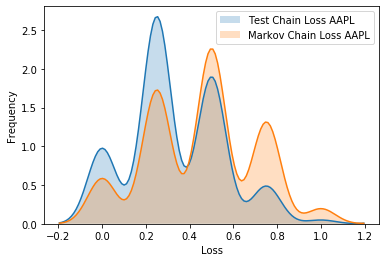

1.2345679012345678% done!


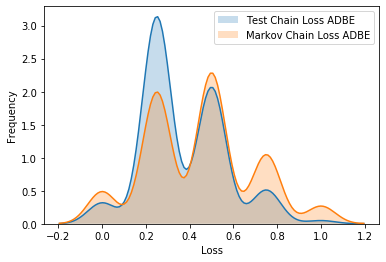

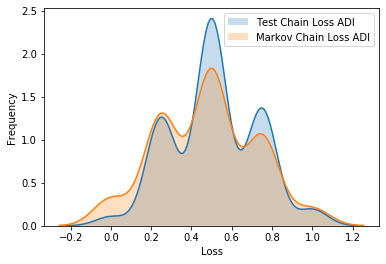

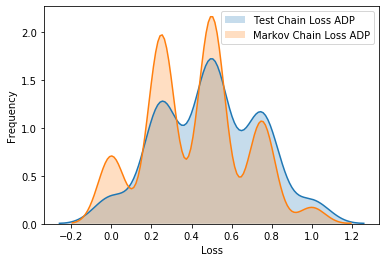

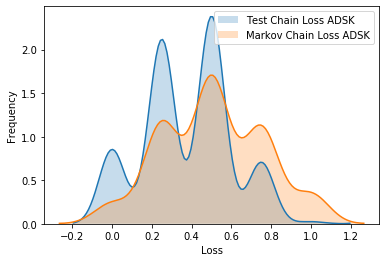

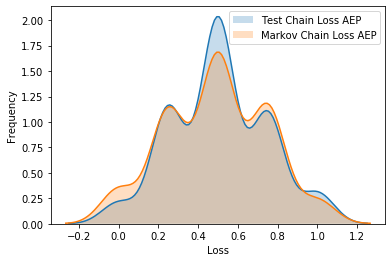

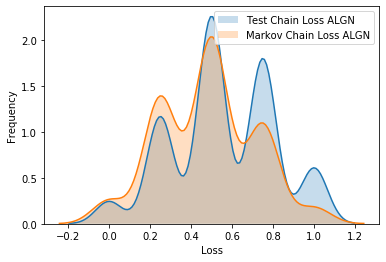

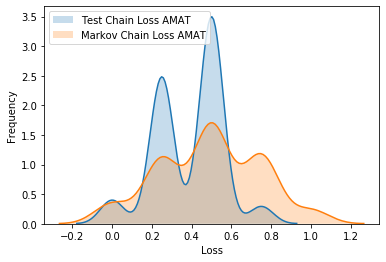

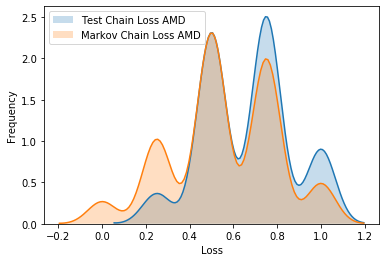

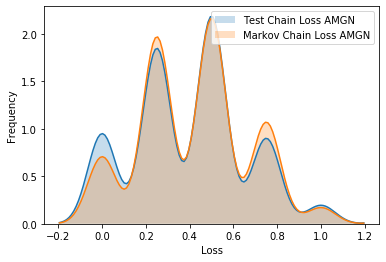

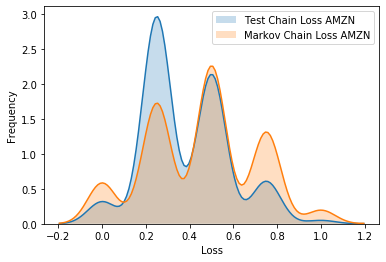

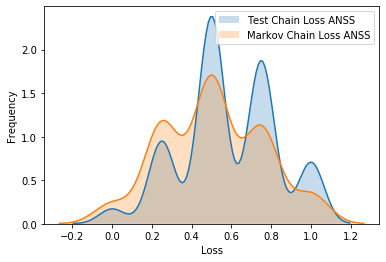

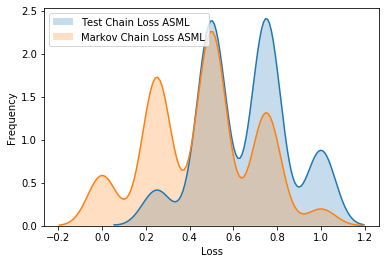

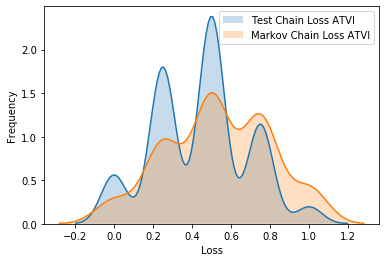

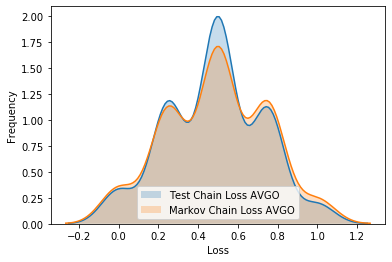

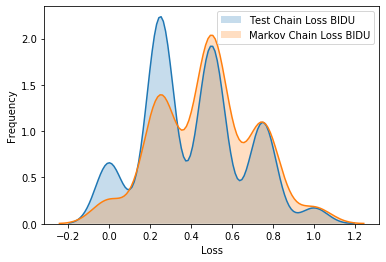

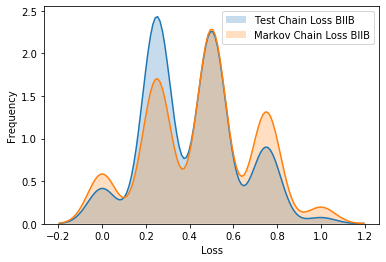

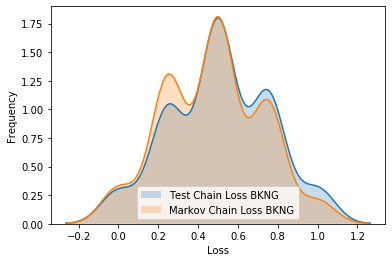

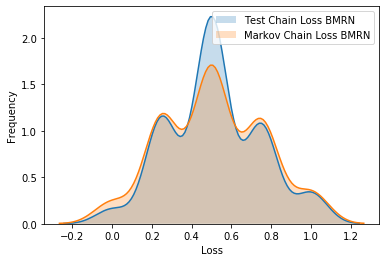

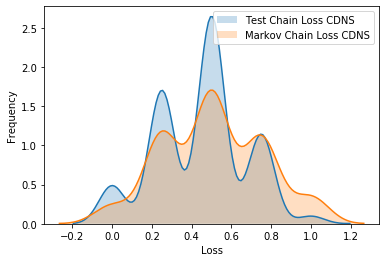

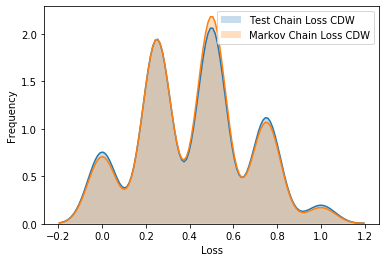

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


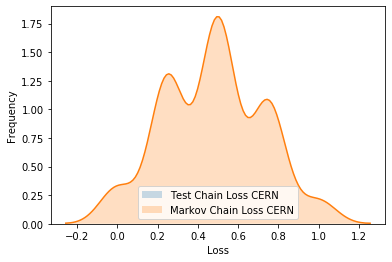

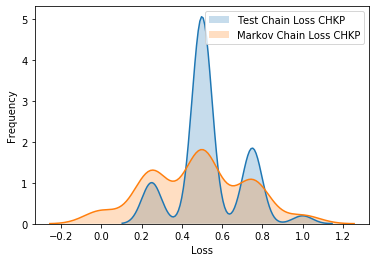

28.395061728395063% done!


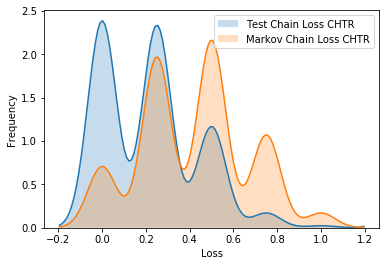

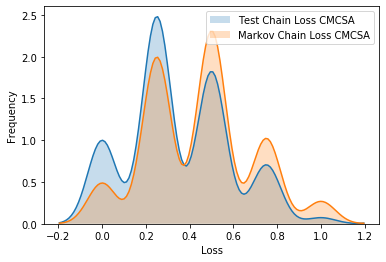

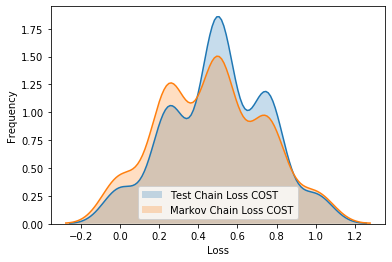

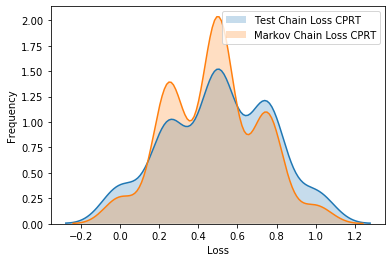

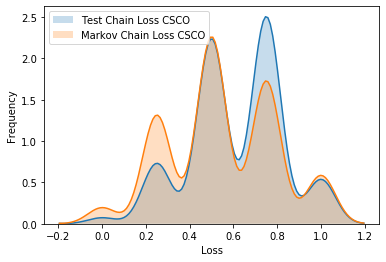

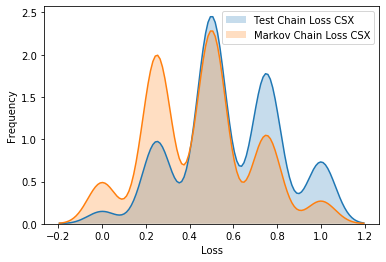

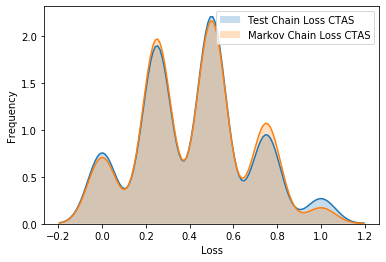

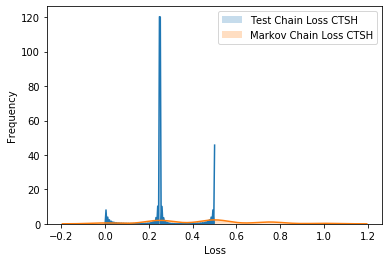

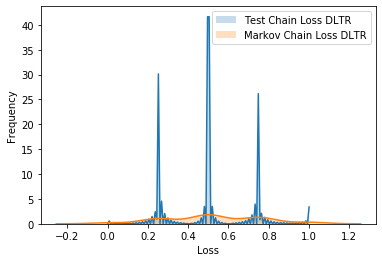

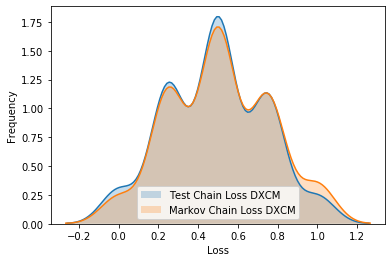

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


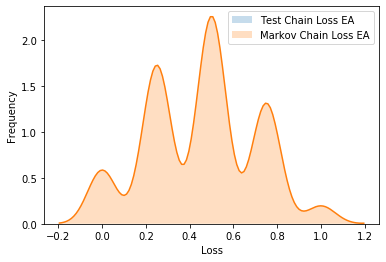

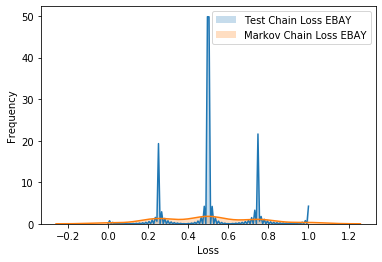

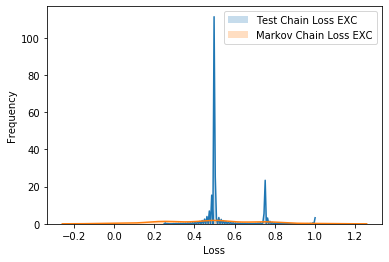

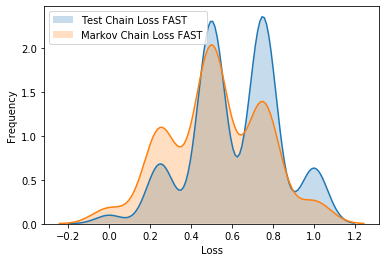

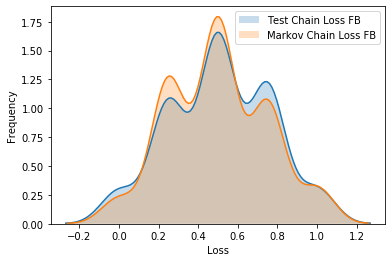

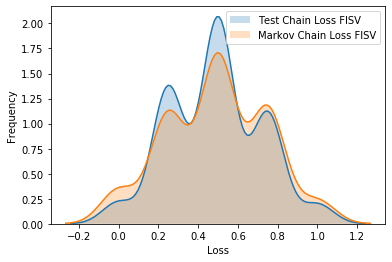

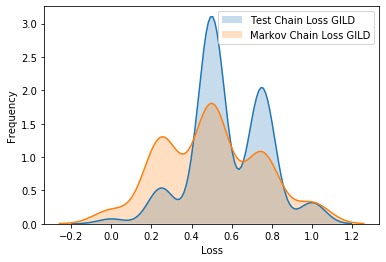

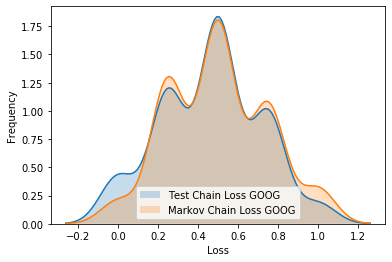

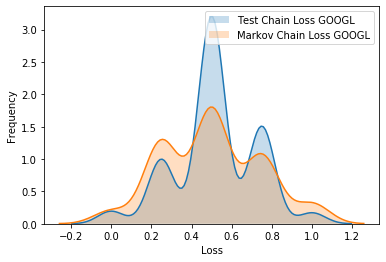

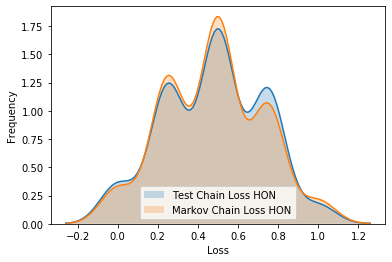

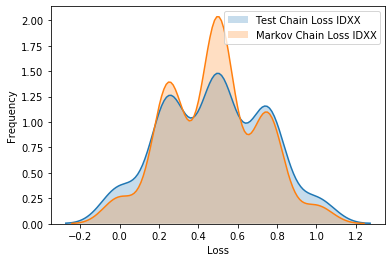

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


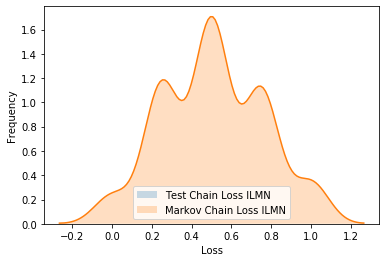

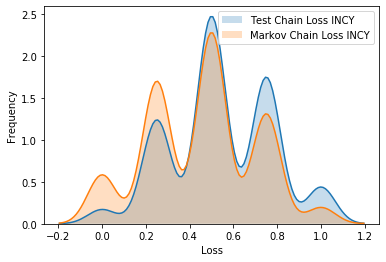

56.79012345679013% done!


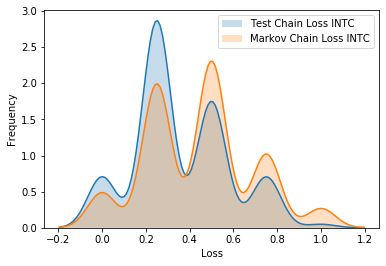

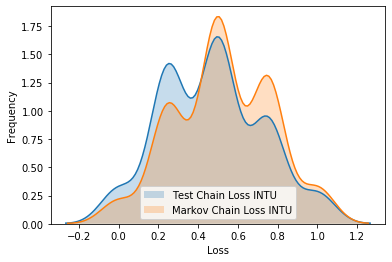

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


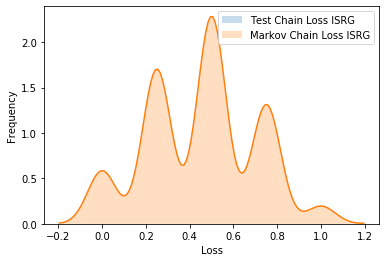

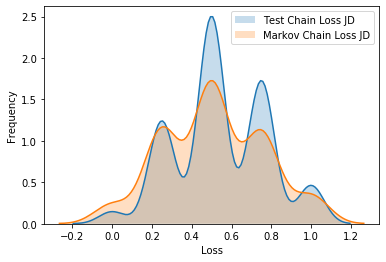

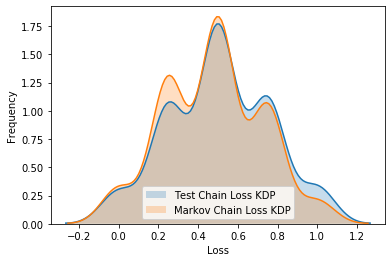

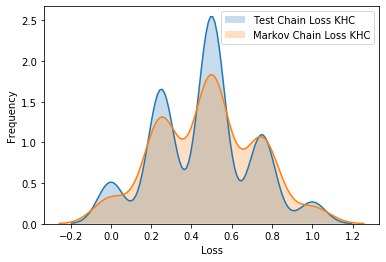

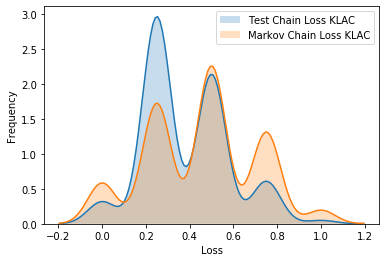

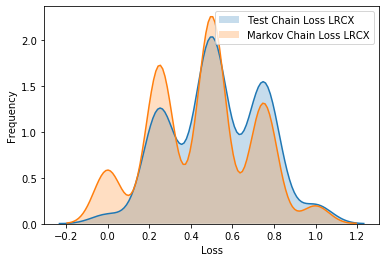

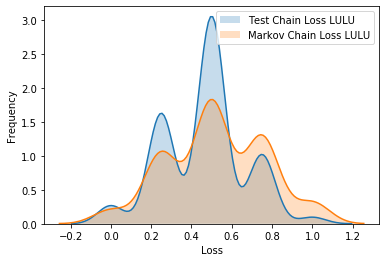

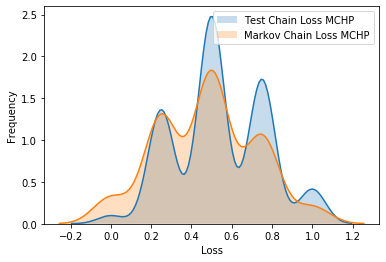

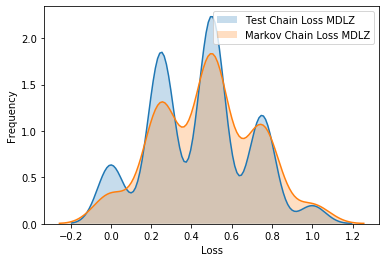

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


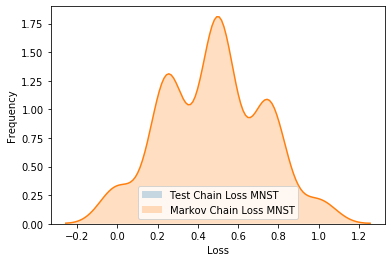

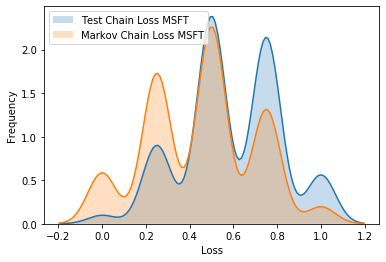

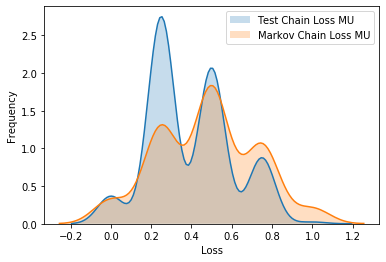

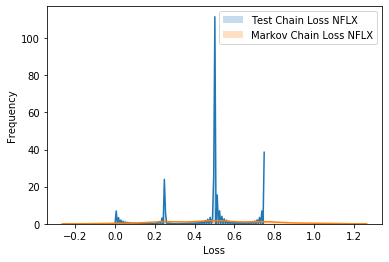

/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:487: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
/Users/austinriis-due/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2


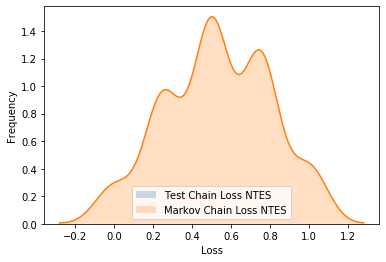

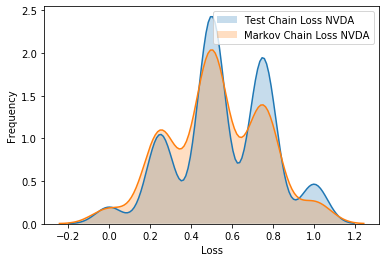

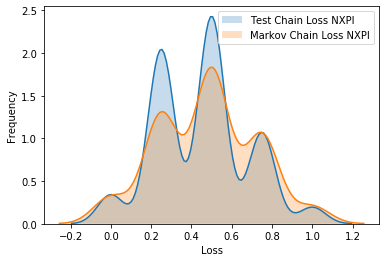

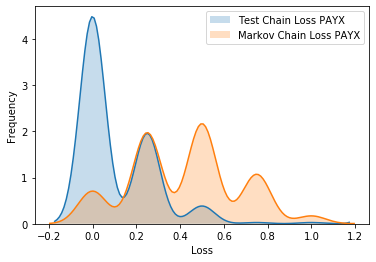

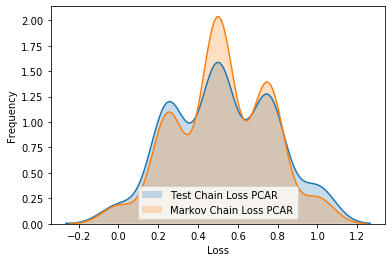

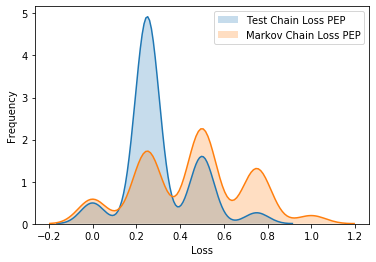

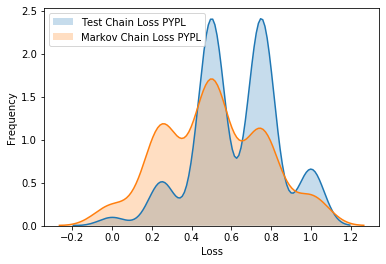

83.95061728395062% done!


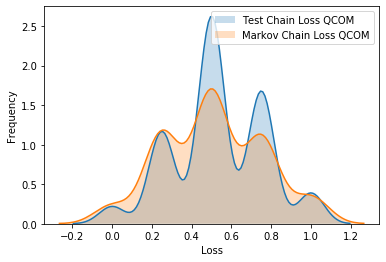

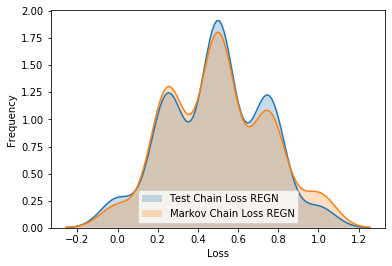

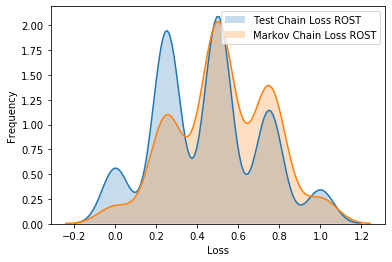

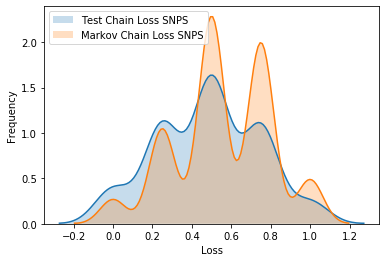

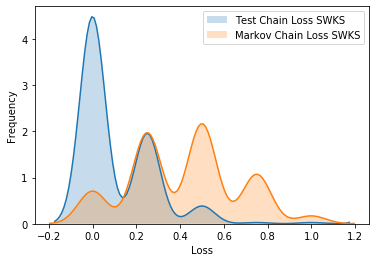

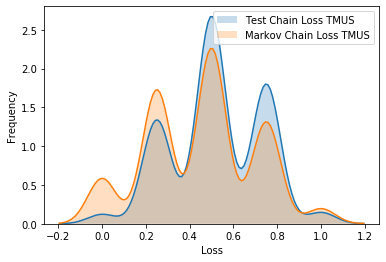

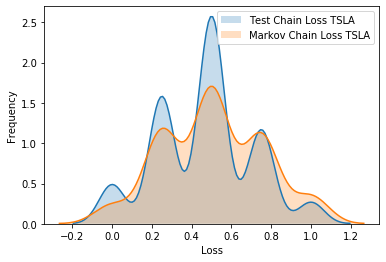

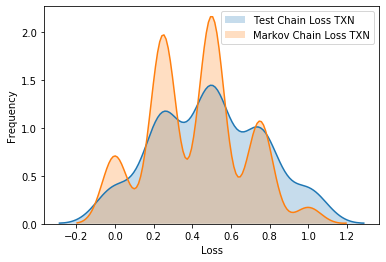

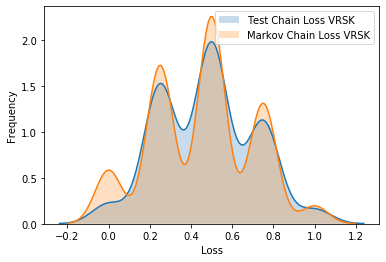

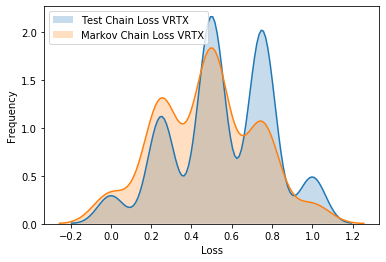

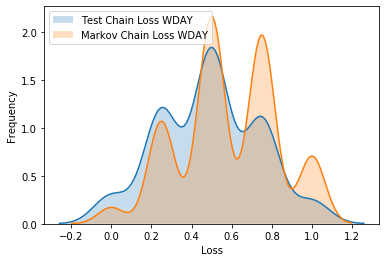

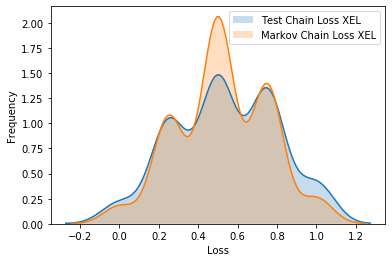

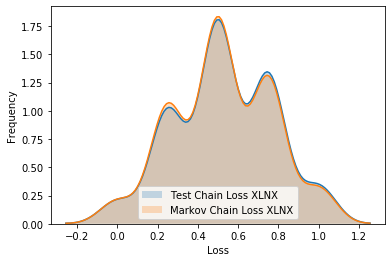

In [11]:
final_out = pd.DataFrame()
final_out["Ticker"] = list(all_data.keys())
testerrorqties = {}
for g in range(len(all_data)):
    if g in [1,23,46,68]:
        print(str(100*g / len(all_data))+"% done!")
    test_comps = [list(all_data.keys())[g]]
    test = npdf.iloc[np.where(npdf["Ticker"] == test_comps[0])]
    train = npdf.iloc[np.where(npdf["Ticker"] != test_comps[0])]
    train.reset_index(drop = True,inplace = True)
    test.reset_index(drop = True,inplace = True)
    npdfu = train.loc[npdf["t0"] == 1]
    npdfd = train.loc[npdf["t0"] == 0]
    n_neighbors = 10
    scale = pd.DataFrame()
    scale["Y"] = norm(npdfu["Y"])
    scale["Z"] = norm(npdfu["Z"])
    upknn = neighbors.KNeighborsClassifier(n_neighbors)
    X = scale[["Y","Z"]]
    y = npdfu["t1"]
    upknn.fit(X,y)
    scale = pd.DataFrame()
    scale["Y"] = norm(npdfd["Y"])
    scale["Z"] = norm(npdfd["Z"])
    downknn = neighbors.KNeighborsClassifier(n_neighbors)
    X = scale[["Y","Z"]]
    y = npdfd["t1"]
    downknn.fit(X,y)
    p = 5
    k = 0
    TEST1 = {}
    test1 = test.loc[test["Ticker"] == test_comps[0]][["t0","t1","Z","Y"]]
    test1.reset_index(drop = True,inplace = True)
    i=0
    while p+k <= len(test1):
        TEST1[i] = test1.iloc[k:p+k]
        k+=1
        i+=1
    np.random.seed(10)
    testloss = []
    n = 250
    for j in [len(TEST1)-1]:
        for i in range(n):
            out = proj(TEST1[j],"Z","Y",len(TEST1[j]),"t0")
            testloss.append(hamming_loss(out[1:],TEST1[j]["t1"][:len(TEST1[j]["t1"])-1]))
    TM = pd.DataFrame(index = [1,0])

    tm = {"UU":0,"UD":0,"DU":0,"DD":0}

    for x in all_data.keys():
        if x not in test_comps:
            tm["UU"] += all_tm[x]["Up"]["Up"]
            tm["DU"] += all_tm[x]["Down"]["Up"]
            tm["UD"] += all_tm[x]["Up"]["Down"]
            tm["DD"] += all_tm[x]["Down"]["Down"]
    TM[1] = [tm["UU"],tm["UD"]]
    TM[0] = [tm["DU"],tm["DD"]]
    TM = scaleMatrix(TM)
    np.random.seed(10)
    ptstest1 = {}
    for i in [len(TEST1)-1]:
        ptstest1[i] = pd.DataFrame()
        ptstest1[i]["t0"] = [TEST1[i]["t0"][0]]
    ptsloss = []
    for j in [len(TEST1)-1]:
        for i in range(n):
            out = chain(init_state = ptstest1[j], matrix = TM, original_states = [1,0], init_state_col = "t0",n=len(TEST1[j])-1)
            ptsloss.append(hamming_loss(out.iloc[0][1:],TEST1[j]["t1"][:len(TEST1[j]["t1"])-1]))
    f = plt.figure(g)
    sns.kdeplot(testloss,shade=True)
    sns.kdeplot(ptsloss,shade=True)
    plt.xlabel("Loss")
    plt.ylabel("Frequency")
    plt.legend(["Test Chain Loss "+str(test_comps[0]),"Markov Chain Loss "+str(test_comps[0])])
    plt.show()
    testerrorqties[test_comps[0]] = {"Proposed Model":[x for x in pd.Series(testloss).describe(percentiles = [0.1+0.1*i for i in range(9)])],"Pure Time Series":[x for x in pd.Series(ptsloss).describe(percentiles = [0.1+0.1*i for i in range(9)])]}

In [12]:
TEST1[j]["t1"][:len(TEST1[j]["t1"])]

0    1.0
1    0.0
2    0.0
3    1.0
4    0.0
Name: t1, dtype: float64

In [13]:
testerrorqties

{'AAPL': {'Proposed Model': [250.0,
   0.334,
   0.21710027664764067,
   0.0,
   0.0,
   0.25,
   0.25,
   0.25,
   0.25,
   0.3500000000000014,
   0.5,
   0.5,
   0.5,
   1.0],
  'Pure Time Series': [250.0,
   0.451,
   0.2471707375357689,
   0.0,
   0.25,
   0.25,
   0.25,
   0.5,
   0.5,
   0.5,
   0.5,
   0.75,
   0.75,
   1.0]},
 'ADBE': {'Proposed Model': [250.0,
   0.37,
   0.189058117750998,
   0.0,
   0.25,
   0.25,
   0.25,
   0.25,
   0.25,
   0.5,
   0.5,
   0.5,
   0.5,
   1.0],
  'Pure Time Series': [250.0,
   0.443,
   0.24338847919987672,
   0.0,
   0.25,
   0.25,
   0.25,
   0.25,
   0.5,
   0.5,
   0.5,
   0.75,
   0.75,
   1.0]},
 'ADI': {'Proposed Model': [250.0,
   0.513,
   0.21156568757868674,
   0.0,
   0.25,
   0.25,
   0.5,
   0.5,
   0.5,
   0.5,
   0.5,
   0.75,
   0.75,
   1.0],
  'Pure Time Series': [250.0,
   0.475,
   0.24261170987210876,
   0.0,
   0.25,
   0.25,
   0.25,
   0.5,
   0.5,
   0.5,
   0.5,
   0.75,
   0.75,
   1.0]},
 'ADP': {'Proposed Mod

In [14]:
{"count":0, 
 "mean":1,
 "std":2,
 "min":3,
 "0.1":4,
 "0.2":5,
 "0.3":6,
 "0.4":7,
 "0.5":8,
 "0.6":9,
 "0.7":10,
 "0.8":11,
 "0.9":12,
 "max":13}

{'count': 0,
 'mean': 1,
 'std': 2,
 'min': 3,
 '0.1': 4,
 '0.2': 5,
 '0.3': 6,
 '0.4': 7,
 '0.5': 8,
 '0.6': 9,
 '0.7': 10,
 '0.8': 11,
 '0.9': 12,
 'max': 13}

In [15]:
pctreductionloss = []
avgcap = []
avgpe = []
q = 1
for x in testerrorqties.keys():
    l = (testerrorqties[x]["Pure Time Series"][q] - testerrorqties[x]["Proposed Model"][q]) / testerrorqties[x]["Pure Time Series"][q]
    pctreductionloss.append(l)
    print(l)
    avgcap.append(all_data[x]["Y"][len(all_data[x])-1])
    avgpe.append(all_data[x]["Z"][len(all_data[x])-1])
lossdf = pd.DataFrame()
lossdf["Reduction"] = pctreductionloss
lossdf["Average Y"] = avgcap
lossdf["Average Z"] = avgpe
lossdf.head()

0.25942350332594233
0.16478555304740408
-0.08000000000000007
-0.1694510739856802
0.2652259332023576
-0.03469387755102044
-0.16561844863731673
0.20977596741344193
-0.18637992831541214
0.04773269689737461
0.15521064301552107
-0.14341846758349697
-0.4501108647450111
0.1688555347091933
0.016293279022403274
0.13417190775681342
0.09513274336283194
-0.06932773109243703
-0.009823182711198437
0.12573673870333987
0.0
-0.05042016806722694
-0.13025210084033625
0.48210023866348445
0.20588235294117652
-0.07280513918629544
-0.05870020964360592
-0.11293260473588332
-0.31151241534988705
-0.004773269689737475
0.4153498871331828
0.06476190476190481
0.03929273084479375
0.44567627494456763
-0.01803607214428859
-0.06722689075630259
-0.1720841300191204
-0.022044088176352724
0.012219959266802456
-0.16399999999999992
0.07199999999999995
-0.038000000000000034
-0.0063157894736842165
-0.010482180293501057
0.017681728880157187
-0.20132743362831865
0.19230769230769235
0.10476190476190485
0.44690265486725667
-0.0705

,Reduction,Average Y,Average Z
0,0.259424,0.787257,0.795819
1,0.164786,-0.676210,0.537301
2,-0.080000,-0.634296,0.269837
3,-0.169451,-0.531031,0.561112
4,0.265226,0.809874,0.506762


In [16]:
lossdf.loc[lossdf["Reduction"] <= 0].describe()

,Reduction,Average Y,Average Z
count,43.000000,43.000000,43.000000
mean,-0.113371,-0.147183,0.321775
std,0.106121,0.635787,0.447899
min,-0.450111,-0.771956,-0.660452
25%,-0.164444,-0.640519,-0.021973
50%,-0.070588,-0.500708,0.464070
75%,-0.036347,0.693917,0.675585
max,0.000000,0.948977,0.943518


In [17]:
lossdf.loc[lossdf["Reduction"] > 0].describe()

,Reduction,Average Y,Average Z
count,38.000000,38.000000,38.000000
mean,0.188254,-0.264602,0.080667
std,0.182713,0.550858,0.445029
min,0.012220,-0.748600,-0.621993
25%,0.066571,-0.614483,-0.318626
50%,0.137832,-0.542155,0.015602
75%,0.208803,-0.285634,0.506366
max,0.747017,0.864166,0.802609


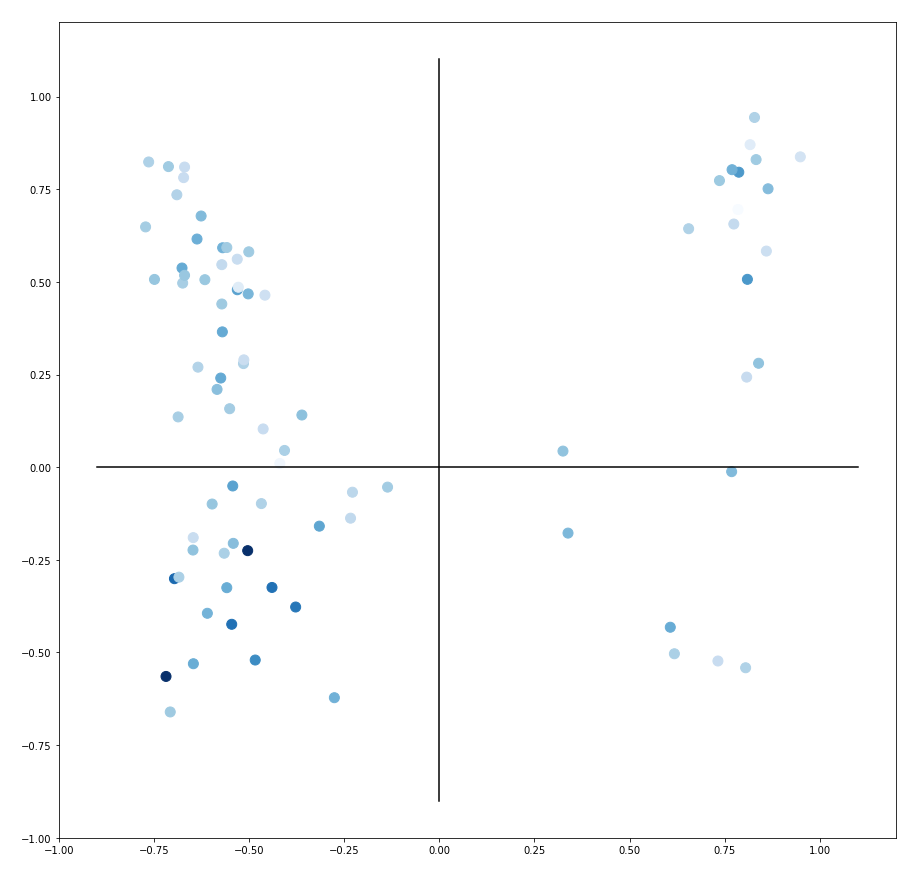

In [18]:
f = plt.figure()
f.set_figwidth(15)
f.set_figheight(15)
plt.scatter(lossdf["Average Y"],lossdf["Average Z"],c = lossdf["Reduction"],cmap="Blues",s = 100)
plt.xlabel("Y",c="white")
plt.ylabel("Z",c="white")
plt.title("Decrease in Loss",loc="left",c="white")
plt.plot([-.9,1.1],[0,0],c="black")
plt.plot([0,0],[-.9,1.1],c="black")
plt.show()

In [19]:
lossdf["Reduction"].describe(percentiles = [0.1+0.1*i for i in range(9)])

count    81.000000
mean      0.028132
std       0.210460
min      -0.450111
10%      -0.169451
20%      -0.138947
30%      -0.067368
40%      -0.034694
50%      -0.004773
60%       0.037895
70%       0.095133
80%       0.155211
90%       0.259424
max       0.747017
Name: Reduction, dtype: float64

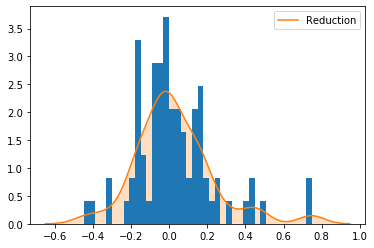

In [20]:
plt.hist(lossdf["Reduction"],density=True,bins=40)
sns.kdeplot(lossdf["Reduction"],shade=True)
plt.show()